## Normalizing Flow Example

Simple Normalizing Flow (RealNVP-style affine coupling) for MNIST using PyTorch.

What it does:
- Implements a simple affine coupling layer with alternating binary masks
- Stacks multiple coupling layers into a flow
- Trains on MNIST by maximizing log-likelihood
- Generates and saves sample images during training

Dependencies:
- torch, torchvision, matplotlib


This implementation is intentionally small and educational rather than highly-optimized.


In [7]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math
import os
from typing import List
from torchvision import transforms, utils


### Utility Masks

In [41]:
def create_checkerboard_mask(h: int, w: int, invert: bool = False) -> torch.Tensor:
    """Create a binary checkerboard mask of shape (1, h, w)."""
    mask = [[((i + j) % 2) for j in range(w)] for i in range(h)]
    # to numpy
    mask = torch.from_numpy(np.array(mask)).float()
    if invert:
        mask = 1.0 - mask
    return mask.unsqueeze(0)  # (1, h, w)

# For a flattened image we'll produce a mask vector of length 784
def mask_flat_from_checkerboard(h=28, w=28, invert=False) -> torch.Tensor:
    return create_checkerboard_mask(h, w, invert).view(-1)  # (784,)

### Coupling Layer

Affine coupling layer as in RealNVP.

In [42]:
class AffineCoupling(nn.Module):
    """Simple MLP-based affine coupling layer (RealNVP style) for flattened images.

    Splits input by mask: x = x_a * mask + x_b * (1-mask)
    Transforms the (1-mask) part conditioned on the mask part.
    """
    def __init__(self, dim: int, hidden: int, mask: torch.Tensor):
        super().__init__()
        self.dim = dim
        self.register_buffer("mask", mask)  # (dim,)

        # NN outputs scale and shift for the transformed subset
        self.net = nn.Sequential(
            nn.Linear(dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, dim * 2),  # s and t for full dim but we'll mask
        )
        # initialize last layer weights near zero for stability at start
        nn.init.normal_(self.net[-1].weight, mean=0.0, std=1e-5)
        nn.init.zeros_(self.net[-1].bias)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        # x shape: (B, dim)
        masked_x = x * self.mask
        params = self.net(masked_x)
        s, t = params.chunk(2, dim=1)
        # apply mask to only transform the complementary part
        s = s * (1 - self.mask)
        t = t * (1 - self.mask)
        # scale activation: clipped for numerical stability
        s = torch.tanh(s) * 2.0  # scale range roughly (-2, 2)

        y = x * torch.exp(s) + t
        # keep masked part unchanged explicitly
        y = y * (1 - self.mask) + masked_x

        # log-determinant is sum of s over transformed dimensions
        log_det = s.sum(dim=1)
        return y, log_det

    def inverse(self, y: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        masked_y = y * self.mask
        params = self.net(masked_y)
        s, t = params.chunk(2, dim=1)
        s = s * (1 - self.mask)
        t = t * (1 - self.mask)
        s = torch.tanh(s) * 2.0
        x = (y - t) * torch.exp(-s)
        x = x * (1 - self.mask) + masked_y
        log_det = -s.sum(dim=1)
        return x, log_det



## Model Architecture

The Normalizing Flow model consists of multiple affine coupling layers, each with its own binary mask. The masks alternate between layers to ensure that all dimensions are transformed over the course of the flow.

In [ ]:
class NormalizingFlow(nn.Module):
    def __init__(self, dim: int, hidden: int, n_layers: int):
        super().__init__()
        self.dim = dim
        self.layers: List[AffineCoupling] = nn.ModuleList()
        # alternate checkerboard masks
        masks = []
        for i in range(n_layers):
            invert = (i % 2 == 1)
            masks.append(mask_flat_from_checkerboard(28, 28, invert=invert))

        for m in masks:
            layer = AffineCoupling(dim=dim, hidden=hidden, mask=m)
            self.layers.append(layer)

        # base distribution is standard normal

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        # x: (B, dim)
        log_det_sum = x.new_zeros(x.size(0))
        z = x
        for layer in self.layers:
            z, log_det = layer(z)
            log_det_sum = log_det_sum + log_det
        return z, log_det_sum

    def inverse(self, z: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        # invert the flow (sample -> data space)
        log_det_sum = z.new_zeros(z.size(0))
        x = z
        for layer in reversed(self.layers):
            x, log_det = layer.inverse(x)
            log_det_sum = log_det_sum + log_det
        return x, log_det_sum

    def log_prob(self, x: torch.Tensor) -> torch.Tensor:
        # compute log p_x(x) = log p_z(z) + log|det dz/dx|
        z, log_det = self.forward(x)
        # standard normal logprob
        log_pz = -0.5 * (z.pow(2).sum(dim=1) + self.dim * math.log(2 * math.pi))
        return log_pz + log_det

    def sample(self, num_samples: int, device: torch.device) -> torch.Tensor:
        z = torch.randn(num_samples, self.dim, device=device)
        x, _ = self.inverse(z)
        return x



## Model Training

The Normalizing Flow model is trained by maximizing the log-likelihood of the training data. The training loop iterates over the dataset, computes the negative log-likelihood loss, and updates the model parameters using the Adam optimizer. The model's performance is monitored by generating and saving sample images at regular intervals during training.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set the number of epochs
num_epochs = 30
batch_size=64
lr=1e-3
n_layers=4
hidden=128
dim = 28 * 28
save_dir="outputs"
os.makedirs(save_dir, exist_ok=True)
model = NormalizingFlow(dim=dim, hidden=hidden, n_layers=n_layers).to(device)
#model = NICEFlow(channels=1, n_layers=n_layers, hidden=hidden, use_global_scale=True).to(device)
print(model)
print(f"Number of model parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f} million")
print(f"Running on: {device}")

transform = transforms.Compose([
    transforms.ToTensor(),  # maps to [0,1]
    # transforms.Lambda(lambda t: (t - 0.5) * 2),  # scale to [-1,1]
    transforms.Lambda(lambda t: t.view(-1)),  # flatten to 784
])
# Load the MNIST train dataset
train_dataset = torchvision.datasets.MNIST(root='~/data', 
                                           train=True, 
                                           download=True, 
                                           transform=transform)

# Create the train dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

# Load the MNIST test dataset
test_dataset = torchvision.datasets.MNIST(root='~/data', 
                                          train=False, 
                                          download=True, 
                                          transform=transform)

# Create the test dataloader
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)


# Define the optimizer and the scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# Set the model to training mode
model.train()
# Train the model for the specified number of epochs
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(device)
        # x is flattened and in [-1,1]
        optimizer.zero_grad()
        log_px = model.log_prob(x)
        # we maximize log-likelihood -> minimize negative log-likelihood
        loss = -log_px.mean()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    
    lr = scheduler.get_last_lr()[0]
    scheduler.step() 
    print(f"Epoch {epoch}, avg loss: {total_loss / (batch_idx + 1):.4f}, lr: {lr:.6f}")

NormalizingFlow(
  (layers): ModuleList(
    (0-3): 4 x AffineCoupling(
      (net): Sequential(
        (0): Linear(in_features=784, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=1568, bias=True)
      )
    )
  )
)
Number of model parameters: 1.28 million
Running on: cuda
Epoch 0, avg loss: -1387.2148, lr: 0.001000
Epoch 1, avg loss: -1634.9104, lr: 0.000997
Epoch 2, avg loss: -1697.7345, lr: 0.000989
Epoch 3, avg loss: -1732.0808, lr: 0.000976
Epoch 4, avg loss: -1753.7155, lr: 0.000957
Epoch 5, avg loss: -1776.6210, lr: 0.000933
Epoch 6, avg loss: -1794.6903, lr: 0.000905
Epoch 7, avg loss: -1808.9942, lr: 0.000872
Epoch 8, avg loss: -1820.8269, lr: 0.000835
Epoch 9, avg loss: -1833.4429, lr: 0.000794
Epoch 10, avg loss: -1847.7405, lr: 0.000750
Epoch 11, avg loss: -1857.0885, lr: 0.000703
Epoch 12, avg loss: -1868.2969, lr: 0.000655
Epoch 13, a

## Model Testing

The trained Normalizing Flow model can be evaluated by generating new samples from the learned distribution. This is done by sampling from a standard normal distribution and passing the samples through the inverse of the flow to obtain images in the original data space.


Sample min: -1.6083287000656128, max: 6.048746109008789
Saved samples to outputs/samples_epoch_29.png


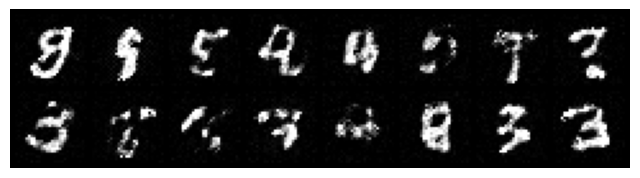

In [58]:
model.eval()
with torch.no_grad():
    samples = model.sample(16, device=device)  # (16, dim)
    imgs = samples.view(-1, 1, 28, 28)
    # print min and max
    min_val = imgs.min().item()
    max_val = imgs.max().item()
    print(f"Sample min: {min_val}, max: {max_val}")
    #imgs = torch.sigmoid(imgs)
    imgs = torch.clamp(imgs, 0.0, 1.0)
    grid = utils.make_grid(imgs, nrow=8, padding=2, normalize=False)
    # save as png
    utils.save_image(grid, os.path.join(save_dir, f"samples_epoch_{epoch}.png"))
    print(f"Saved samples to {os.path.join(save_dir, f'samples_epoch_{epoch}.png')}")

    # visualize the samples inline (if using Jupyter)
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    plt.show()